In [1]:
import sys
workPath = '/home/jovyan/workspace'
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
from timeit import timeit

In [3]:
import planetengine
outputPath = planetengine.paths.make_testdir()
from planetengine import quickShow
from planetengine import functions as pfn

In [4]:
system = planetengine.tests.testsystems.isovisc(Ra = 1e4, res = 64)

Fitted 1 variables to the figure.


In [5]:
system.go(100)

Fitted 1 variables to the figure.
Variable_varName=anon{}



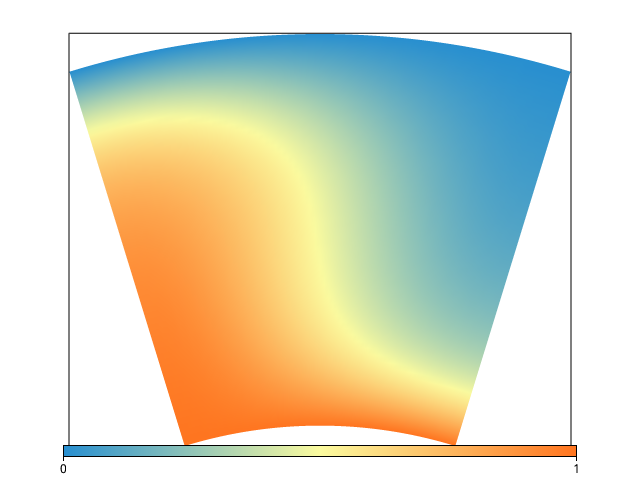

In [6]:
quickShow(system.temperatureField)

In [15]:
vector_component_funcs = [
    pfn.Component.ang,
    pfn.Component.rad
    ]

scalar_gradient_funcs = [
    pfn.Gradient.mag,
    pfn.Gradient.ang,
    pfn.Gradient.rad
    ]

scalar_surface_funcs = [
    pfn.Surface.outer,
    pfn.Surface.inner,
    ]

# scalar_quantile_funcs = [
#     lambda quantVar, inVar: pfn.Select(
#             quantVar,
#             float(x),
#             inVar
#             ) \
#         for x in range(1, 4)
#     ]

scalar_reduction_funcs = [
    pfn.Integral.auto,
    pfn.GetStat.mins,
    pfn.GetStat.maxs
    ]

def var_expander(varList, funcList):
    outList = [func(var) for func in funcList for var in varList]
    for item in outList:
        print(item.opTag)
    return outList

def make_obsVars_var(inVar):

    obsVars = []
    inVar = pfn.convert(inVar)

    if inVar.varDim == 1:
        compVars = []
        baseVar = inVar
    elif inVar.varDim == 2:
        component_funcs = vector_component_funcs
        compVars = [func(inVar) for func in component_funcs]
        baseVar = pfn.Component.mag(inVar)
    else:
        raise Exception

    gradient_funcs = scalar_gradient_funcs
    gradVars = [
        func(var) \
            for func in gradient_funcs \
                for var in [baseVar, *compVars]
        ]

    varList = [baseVar, *gradVars]
    surfVars = []
    for var in varList:
        for index, func in enumerate(scalar_surface_funcs):
            if var.bounds[0][index] == '.':
                surfVars.append(func(var))
    surfVars = gradVars

    quantVars = [
        (pfn.Quantiles.terciles(var), var) \
            for var in [baseVar, *surfVars]
        ]
    selectVars = []
    for x in range(1, 4):
        selectVars.extend([
            pfn.Select(
                    inTup[0],
                    float(x),
                    inTup[1]
                    ) \
                for inTup in quantVars
            ])

    terminalVars = [baseVar, *selectVars]
    redVars = []
    for terminalVar in terminalVars:
        redVars.append(pfn.Integral.auto(terminalVar))
        if all([scale == ['.', '.'] for scale in terminalVar.scales]):
            redVars.append(pfn.GetStat.mins(terminalVar))
            redVars.append(pfn.GetStat.maxs(terminalVar))

    obsVars = redVars

    return obsVars

def make_obsVars(inVars):
    inVars = pfn.convert(inVars)
    if type(inVars) == dict:
        inVars = [
            var \
                for varName, var in sorted(
                    inVars.items()
                )
            ]
    obsVars = []
    for inVar in inVars:
        obsVars.extend(
            make_obsVars_var(inVar)
            )
    return obsVars

def _make_dict_obsVars(obsVars):
    varDict = {}
    for var in obsVars:
        varDict[var.varName] = var
    return varDict

def make_obsVars_dict(inVars):
    return _make_dict_obsVars(make_obsVars(inVars))

In [16]:
myVars = {
    'temperature': system.temperatureField,
    'velocity': system.velocityField,
    'stress': system.viscosityFn * system.velocityField
    }

In [17]:
def testfn():
    statsDict = make_obsVars_dict(myVars)
timeit(testfn, number = 1)

free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found
free surface found


61.54902179999954

In [10]:
statsDict = make_obsVars_dict(myVars)

In [14]:
statsDict

{'Integral_surface=volume{HandleNaN{Component_component=ang{Gradient{Projection{Component_component=ang{Variable_varName=stress{}}}}};Constant_val=arr{[ 0.]}{}}}': <planetengine.functions.Integral at 0x7f1641b17908>,
 'Integral_surface=volume{HandleNaN{Component_component=ang{Gradient{Projection{Component_component=ang{Variable_varName=velocity{}}}}};Constant_val=arr{[ 0.]}{}}}': <planetengine.functions.Integral at 0x7f16419e4438>,
 'Integral_surface=volume{HandleNaN{Component_component=ang{Gradient{Projection{Component_component=mag{Variable_varName=stress{}}}}};Constant_val=arr{[ 0.]}{}}}': <planetengine.functions.Integral at 0x7f16419f1b00>,
 'Integral_surface=volume{HandleNaN{Component_component=ang{Gradient{Projection{Component_component=mag{Variable_varName=velocity{}}}}};Constant_val=arr{[ 0.]}{}}}': <planetengine.functions.Integral at 0x7f16419d7748>,
 'Integral_surface=volume{HandleNaN{Component_component=ang{Gradient{Projection{Component_component=rad{Variable_varName=stress{

In [11]:
len(statsDict)

24

In [12]:
def testfn():
    for name, var in sorted(statsDict.items()):
        var.evaluate()
system.iterate()
print(round(timeit(testfn, number = 3) / 3., 3))
print(round(timeit(testfn, number = 3) / 3., 3))
system.iterate()
print(round(timeit(testfn, number = 3) / 3., 3))
print(round(timeit(testfn, number = 3) / 3., 3))

0.834
0.009
0.521
0.009


In [13]:
# def testfn():
# #     statsDict = make_obsVars_dict(system.obsVars)
#     var = make_obsVars_var(system.temperatureField)
# timeit(testfn, number = 1)